In [87]:
# from google.colab import drive
# drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
'1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
'1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz',
'1wuDhxLk2QAmvio-iGVUyLWZbp8DfY8OI': 'test_yolo_loss.npz' }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing




In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils import data
from sklearn import metrics

### Train - Test Split and Process y label

In [ ]:
def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  img_obj = np.load(image_path,allow_pickle=True,encoding='latin1')
  label_obj = np.load(labels_path,allow_pickle=True,encoding='latin1')
  images = img_obj['arr_0']
  labels = label_obj['arr_0']

  # Number of training data
  n_train = int(np.ceil(0.8 * images.shape[0]))

  # Generate random id's
  ids = np.random.permutation(images.shape[0])
  train_ids,test_ids = ids[:n_train],ids[n_train:]

  # Split the data
  train_images = images[train_ids,:,:,:]
  train_raw_lables = labels[train_ids]

  test_images = images[test_ids,:,:,:]
  test_raw_labels = labels[test_ids]

  return train_images, train_raw_lables, test_images, test_raw_labels

def create_y_label(image, raw_label):
  ## this function should compute the 8X8X8 label from the raw labels for the corresponding image.
  label = raw_label
  # Compute the centers for x and y
  center_x = (label[:,1]+label[:,3])/2
  center_y = (label[:,2]+label[:,4])/2
  pro_y_label = np.zeros((8,8,8))
  grid_size_x = 16
  grid_size_y = 16
  img_x_size = 128
  img_y_size = 128

  # Compute the grid coordinates
  grid_x = np.floor(center_x/grid_size_x).astype(int)
  grid_y = np.floor(center_y/grid_size_y).astype(int)
  pro_y_label[0,grid_x,grid_y]=1

  # Compute the offesys in x any y within each grid cell
  x_off = (center_x % grid_size_x)/grid_size_x
  y_off = (center_y % grid_size_y)/grid_size_y
  pro_y_label[1,grid_x,grid_y]= x_off
  pro_y_label[2,grid_x,grid_y]= y_off

  # Compute the widths and heights
  w =  np.absolute((label[:,1]-label[:,3]))/img_x_size
  h = np.absolute((label[:,2]-label[:,4]))/img_y_size
  pro_y_label[3,grid_x,grid_y]= w
  pro_y_label[4,grid_x,grid_y]= h

  # Compute the class labels
  clas = label[:,0].astype(int) + 5

  for i in range(clas.shape[0]):
    pro_y_label[5:,grid_x[i],grid_y[i]]= 0
    pro_y_label[clas[i],grid_x[i],grid_y[i]]= 1
  return pro_y_label

train_images, train_raw_lables, test_images, test_raw_labels = loadData("images.npz","labels.npz")


In [ ]:
# np.save('/content/drive/My Drive/train_images',train_images)
# np.save('/content/drive/My Drive/train_raw_lables',train_raw_lables)
# np.save('/content/drive/My Drive/test_images',test_images)
# np.save('/content/drive/My Drive/test_raw_labels',test_raw_labels)

In [ ]:
# train_images = np.load('/content/drive/My Drive/train_images.npy',allow_pickle=True)
# train_raw_labels = np.load('/content/drive/My Drive/train_raw_lables.npy',allow_pickle=True)
# test_images = np.load('/content/drive/My Drive/test_images.npy',allow_pickle=True)
# test_raw_labels = np.load('/content/drive/My Drive/test_raw_labels.npy',allow_pickle=True)

In [ ]:
# Function to convert grid coordinates to image pixel space
def grid_to_pix(pro_y,ground_label):
  x_grid_size = 16
  y_grid_size = 16
  img_x_size = 128
  img_y_size = 128

  # Find the non zero id's
  x_grid_id, y_grid_id = torch.nonzero(ground_label,as_tuple=True)
  x_off,y_off = pro_y[1,x_grid_id,y_grid_id],pro_y[2,x_grid_id,y_grid_id]
  
  #Get the x and y centers in pixel space 
  x_center,y_center = (x_grid_id + x_off)*x_grid_size,(y_grid_id + y_off)*y_grid_size
  width, height = pro_y[3,x_grid_id,y_grid_id]*img_x_size, pro_y[4,x_grid_id,y_grid_id]*img_y_size

  # Get the diagonal coordinates 
  x1 = x_center - (width/2)
  y1 = y_center - (height/2)

  x2 = x_center + (width/2)
  y2 = y_center + (height/2)

  return x1,y1,x2,y2,x_center,y_center,width,height

In [ ]:
# Visualization function
def draw_b_box(image,label,raw_label = False):  
  fig = plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.xticks(())
  plt.yticks(())
  ax = plt.gca()
  
  if (not raw_label):
    label = torch.tensor(label)
    ground_label  = label[0,:,:]
    x_grid_id, y_grid_id = torch.nonzero(ground_label,as_tuple=True)

    if (x_grid_id.shape[0] == 0):
      print("No objects detected")
      return

    classes = torch.argmax(label[5:,x_grid_id,y_grid_id],0)
    x1,y1,_,_,_,_,widths,heights = grid_to_pix(label,ground_label)
    plt.title("Processed label")
    
  else:
    classes = label[:,0]
    x1 = label[:,1]
    y1 = label[:,2]
    widths = label[:,3] - label[:,1]
    heights = label[:,4] - label[:,2]
    plt.title("Raw label")
  

  for i in range(x1.shape[0]):
    clas = classes[i]
    # Pedestrian class
    if clas == 0:
      rect = patches.Rectangle((x1[i],y1[i]),widths[i],heights[i],linewidth=1,edgecolor='r',facecolor='none')
    # Traffic light class
    elif clas == 1:
      rect = patches.Rectangle((x1[i],y1[i]),widths[i],heights[i],linewidth=1,edgecolor='b',facecolor='none')
    # Car class
    else:
      rect = patches.Rectangle((x1[i],y1[i]),widths[i],heights[i],linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect)

In [ ]:
from torch.utils import data
# Dataset class
class Image_Datset(data.Dataset):
  def __init__(self,x_list,y_list):
    self.x_list = x_list
    self.y_list = y_list

  def __getitem__(self, id):
    image = self.x_list[id].transpose(2,0,1)
    label = create_y_label(image,self.y_list[id])
    return image,label

  def __len__(self):
    return self.x_list.shape[0]

BATCH_SIZE = 64

train_data = Image_Datset(train_images,train_raw_labels)
train_loader = DataLoader(train_data,batch_size= BATCH_SIZE, shuffle = True)

# Model Definition

In [ ]:
class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,32,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        torch.nn.ConvTranspose2d(1024,256,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        torch.nn.ConvTranspose2d(256,64,kernel_size= 4,padding= 1,stride = 2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,8,kernel_size= 3,padding= 1,stride = 1),
        nn.Sigmoid()
    )

  def forward(self, X):
    out = self.conv(X)
    return out


In [ ]:
def IOU(prediction, grnd_truth):
  batch_size = prediction.shape[0]
  iou_batch = torch.zeros((batch_size,8,8))
  for i in range(batch_size):
    ground_label = grnd_truth[i,0,:,:]
    pred_label = prediction[i,0,:,:]
    
    #Convert grid space to pixel space
    x1,y1,x2,y2,_,_,_,_ = grid_to_pix(grnd_truth[i],ground_label)
    x1_pred,y1_pred,x2_pred,y2_pred,_,_,_,_ = grid_to_pix(prediction[i],ground_label)
    x_grid_id, y_grid_id = torch.nonzero(ground_label,as_tuple=True)

    # Get the overlap co-ordinates
    left_bound = torch.where(x1.double() > x1_pred.double(),x1.double(),x1_pred.double()).float()
    right_bound = torch.where(x2.double() < x2_pred.double(),x2.double(),x2_pred.double()).float()
    lower_bound = torch.where(y1.double() > y1_pred.double(),y1.double(),y1_pred.double()).float()
    upper_bound = torch.where(y2.double() < y2_pred.double(),y2.double(),y2_pred.double()).float()

    overlap_area = (right_bound - left_bound) * (upper_bound - lower_bound)
    
    # If no overlap set it to 0
    overlap_area[(right_bound - left_bound)< 0] = 0
    overlap_area[(upper_bound - lower_bound)< 0] = 0

    # Get the actual area
    actual_area = torch.abs((x2 - x1) * (y2-y1))
    pred_area = torch.abs((x2_pred - x1_pred) * (y2_pred - y1_pred))

    # Compute IoU
    iou = overlap_area/(actual_area+pred_area - overlap_area + 0.000001)

    iou_ones = torch.ones_like(ground_label)
    iou_ones[x_grid_id,y_grid_id] = iou
    iou_batch[i,:,:] = iou_ones * ground_label

  return iou_batch

def YoloLoss(output, target, lambda_coord, lambda_noobj):

  # Get the 1obj
  obj_ind = target[:,0,:,:].clone()

  # Get the 1no_obj
  no_obj_ind = torch.where(obj_ind.double()<1,torch.ones_like(obj_ind.double()),torch.zeros_like(obj_ind.double())).float()

  # Compute the localization error
  loc_error = ((target[:,1,:,:] - output[:,1,:,:]).square()+(target[:,2,:,:] - output[:,2,:,:]).square())*obj_ind

  # Compute the aspect ratio error
  aspect_error = ((target[:,3,:,:].sqrt() - output[:,3,:,:].sqrt()).square()+(target[:,4,:,:].sqrt() - output[:,4,:,:].sqrt()).square())*obj_ind

  # Compute the confidence error with objects
  # c_err = (output[:,0,:,:] - IOU(output, target)).square() * obj_ind
  c_err = (output[:,0,:,:] - target[:,0,:,:]).square() * obj_ind

  # Compute the confidence error without objects
  c_err_nobj = (output[:,0,:,:] - target[:,0,:,:]).square() * no_obj_ind
  err_prob = ((output[:,5:,:,:] - target[:,5:,:,:]).square()).sum(1)*obj_ind

  # Get the total loss
  loss = lambda_coord * (torch.sum(loc_error) + torch.sum(aspect_error)) + torch.sum(c_err) + lambda_noobj*torch.sum(c_err_nobj) + torch.sum(err_prob)

  return loss

In [ ]:
# IOU for any two grids
def non_max_iou(stack,x_grid_id,y_grid_id):
  x_grid_size = 16
  y_grid_size = 16
  img_x_size = 128
  img_y_size = 128

  x_off,y_off = stack[1,:],stack[2,:]

  #Get the x and y centers in pixel space 
  x_center,y_center = (x_grid_id + x_off)*x_grid_size,(y_grid_id + y_off)*y_grid_size
  width,height = stack[3,:]*img_x_size,stack[4,:]*img_y_size
  
  # Get the diagonal coordinates 
  x1 = x_center - (width/2)
  y1 = y_center - (height/2)

  x2 = x_center + (width/2)
  y2 = y_center + (height/2)
  
  left_bound = np.max(x1)
  right_bound = np.min(x2)
  lower_bound = np.max(y1)
  upper_bound = np.min(y2)

  overlap_area = (right_bound - left_bound) * (upper_bound - lower_bound)
  
  if ((right_bound - left_bound) < 0):
    overlap_area = 0
  elif ((upper_bound - lower_bound)<0):
    overlap_area = 0
  
  area1 = (x2[0] - x1[0]) * (y2[0]-y1[0])
  area2 = (x2[1] - x1[1]) * (y2[1]-y1[1])
  
  iou = overlap_area/(area1+area2 - overlap_area + 0.000001)

  return iou


In [ ]:
# Perform grouping and retain the bbox with higest confidence
def modify_pred(pred,x_id,y_id,conf):
  overlap_id = []
  sorted_id = np.argsort(-conf)
  arr_x_y_conf = np.zeros((sorted_id.shape[0],3))
  arr_x_y_conf[:,0] = x_id[sorted_id].flatten()
  arr_x_y_conf[:,1] = y_id[sorted_id].flatten()
  arr_x_y_conf[:,2] = conf[sorted_id].flatten()

  size = sorted_id.shape[0]
  i = 0

  # Loop through all the bboxes and compare
  while (i<size):
    j_id =[]
    for j in range(i+1,size):
      x_grid_id = [int(arr_x_y_conf[i,0]),int(arr_x_y_conf[j,0])]
      y_grid_id = [int(arr_x_y_conf[i,1]),int(arr_x_y_conf[j,1])]
      iou = non_max_iou(pred[:,x_grid_id,y_grid_id],x_grid_id,y_grid_id)
      if (iou>0.5):
        overlap_id.append(arr_x_y_conf[j,:])
        j_id.append(j)
    
    arr_x_y_conf = np.delete(arr_x_y_conf,j_id,0)
    size -= len(j_id)    
    i+=1 
  
  overlap_id = np.array(overlap_id)
  if (overlap_id.shape[0]!=0):
    pred[0,overlap_id[:,0].astype(int),overlap_id[:,1].astype(int)] = 0
  
  return pred

In [ ]:
def NMS(pred):
  thresh = 0.3
  pred = pred.detach().clone().numpy()

  # Remove the bboxes with lesser confidence
  pred[0,pred[0,:,:]<thresh] = 0
  
  x_id,y_id = np.nonzero(pred[0,:,:])
  classes = np.argmax(pred[5:,x_id,y_id],0)

  # For Pedestrian
  id = np.argwhere(classes == 0)
  ped_x_id = x_id[id]
  ped_y_id = y_id[id]
  if (id.shape[0]!=0):
    ped_conf = pred[0,ped_x_id,ped_y_id].flatten()
    pred = modify_pred(pred,ped_x_id,ped_y_id,ped_conf)
    
  # For Traffic Light
  id = np.argwhere(classes == 1)
  traf_x_id = x_id[id]
  traf_y_id = y_id[id]
  if (id.shape[0]!=0):
    traf_conf = pred[0,traf_x_id,traf_y_id].flatten()
    pred = modify_pred(pred,traf_x_id,traf_y_id,traf_conf)

  # For Car
  id = np.argwhere(classes == 2)
  car_x_id = x_id[id]
  car_y_id = y_id[id]
  if (id.shape[0]!=0):
    car_conf = pred[0,car_x_id,car_y_id].flatten()
    pred = modify_pred(pred,car_x_id,car_y_id,car_conf)
  
  return pred

In [ ]:
def yolo_evaluate(pred,target,class_no):
  x_id,y_id = np.nonzero(pred[0,:,:])
  classes = np.argmax(pred[5:,x_id,y_id],0)

  true_x_id,true_y_id = np.nonzero(target[0,:,:])
  true_classes = np.argmax(target[5:,true_x_id,true_y_id],0)

  true_id = np.argwhere(true_classes == class_no)
  true_class_x_id = true_x_id[true_id]
  true_class_y_id = true_y_id[true_id] 

  # Total true labels in the image for this class
  trues = true_id.shape[0]

  id = np.argwhere(classes == class_no)

  class_x_id = x_id[id]
  class_y_id = y_id[id]

  match = []
  conf = []
  if (id.shape[0]!=0):
    class_conf = pred[0,class_x_id,class_y_id].flatten()
    stack = np.zeros((8,2))

    # Find if there is a match for a predicted bbox with the ground truth labels
    for i in range(id.shape[0]):
      max_iou = 0
      stack[:,0] = pred[:,class_x_id[i],class_y_id[i]].flatten()
      
      for j in range(trues):
        stack[:,1] = pred[:,true_class_x_id[j],true_class_y_id[j]].flatten()
        iou = non_max_iou(stack,[int(class_x_id[i]),int(true_class_x_id[j])],[int(class_y_id[i]),int(true_class_y_id[j])])
      
        if (iou>max_iou):
          max_iou = iou

      if (max_iou>0.5):
        match.append(1)
      else:
        match.append(0)
      conf.append(pred[0,class_x_id[i],class_y_id[i]][0])
  
  return match,conf,trues

In [ ]:
def average_p(match,score,trues):
  # Get the maximum score
  if (len(score)):
    max_score = max(score)
  else:
    max_score = 0

  thresh = 0.3

  if (max_score < thresh):
    return 0

  # Different threshold values
  thresh_list = list(np.linspace(thresh,max_score,100))
  score = np.array(score)
  match =np.array(match)

  precisions = []
  recalls = []

  # Calculate precision and recall value for all thresholds
  for i in thresh_list:
    ids = np.argwhere(score > i).astype(int)
    match_abv_thresh = match[ids]
    
    true_false_positive = match_abv_thresh.shape[0]
    true_positive = np.argwhere(match_abv_thresh == 1).shape[0]

    if (true_positive == 0):
      preci = 1
    else:
      preci = true_positive/(true_false_positive+0.000001)
    
    recal = true_positive/trues
    precisions.append(preci)
    recalls.append(recal)
  
  recalls = np.array(recalls)
  precisions = np.array(precisions)

  sorted_id = np.argsort(recalls)
  recalls = recalls[sorted_id]
  precisions = precisions[sorted_id]
  ap = metrics.auc(recalls, precisions)
  # plt.figure()
  # plt.ylabel("Precision")
  # plt.xlabel("Recall")
  # plt.plot(list(recalls),list(precisions))
  return ap 

In [111]:
def MAP(yolo_net,test_images,test_raw_labels,device):
  ped_match = []
  ped_score = []
  ped_trues = 0
  traf_match = []
  traf_score = []
  traf_trues = 0
  car_match = []
  car_score = []
  car_trues = 0

  for i in range(test_images.shape[0]):
    image = torch.tensor(np.expand_dims(test_images[i].transpose(2,0,1),0))
    target = create_y_label([],test_raw_labels[i])

    out = yolo_net(image.float().to(device)).cpu()
    img = image.detach().numpy()[0].transpose(1,2,0)

    pred = NMS(out[0])

    match,score,trues = yolo_evaluate(pred,target,0)
    ped_match += match
    ped_score += score
    ped_trues += trues

    match,score,trues = yolo_evaluate(pred,target,1)
    traf_match += match
    traf_score += score
    traf_trues += trues

    match,score,trues = yolo_evaluate(pred,target,2)
    car_match += match
    car_score += score
    car_trues += trues

  ped_ap = average_p(ped_match,ped_score,ped_trues)
  car_ap = average_p(car_match,car_score,car_trues)
  traf_ap = average_p(traf_match,traf_score,traf_trues)

  no = 3
  if (ped_ap == 0):
    no -=1
  if (car_ap == 0):
    no -=1
  if (traf_ap == 0):
    no -=1

  mean_ap = (ped_ap + car_ap + traf_ap)/(no+0.000001)

  return mean_ap

###Training the network

In [ ]:
torch.manual_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

yolo_net=YOLO()
yolo_net=yolo_net.to(device)

learning_rate = 1e-4

optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate)
  
num_epochs = 25
loss_list = []
map_list = []
lambda_coord= 5
lambda_noobj =0.5

for epoch in range(num_epochs):
    
  yolo_net.train()
  print("Epoch %d/%d" % (epoch+1, num_epochs))
  loss_epoch = 0

  for i,(img,label) in enumerate(train_loader):
    optimizer.zero_grad()
    out = yolo_net(img.float().to(device)).cpu()
    loss = YoloLoss(out,label,lambda_coord,lambda_noobj)
    loss_epoch += loss.data.item()
    loss.backward()
    optimizer.step()
  
  loss_list.append(loss_epoch/(i+1))
  print("Epoch loss:%f" %(loss_epoch/(i+1)))

  yolo_net.eval()
  map = MAP(yolo_net,test_images,test_raw_labels,device)
  map_list.append(map)
  print("Epoch MAP:%f" %(map))


cuda
Epoch 1/25
Epoch loss:531.409624
Epoch MAP:0.252525
Epoch 2/25
Epoch loss:367.595127
Epoch MAP:0.332235
Epoch 3/25
Epoch loss:259.302048
Epoch MAP:0.422135
Epoch 4/25
Epoch loss:164.979832
Epoch MAP:0.304327
Epoch 5/25
Epoch loss:109.474394
Epoch MAP:0.322000
Epoch 6/25
Epoch loss:75.256471
Epoch MAP:0.350426
Epoch 7/25
Epoch loss:53.648203
Epoch MAP:0.388800
Epoch 8/25
Epoch loss:39.047509
Epoch MAP:0.408014
Epoch 9/25
Epoch loss:29.316105
Epoch MAP:0.423123
Epoch 10/25
Epoch loss:23.040743
Epoch MAP:0.432349
Epoch 11/25
Epoch loss:19.572081
Epoch MAP:0.431541
Epoch 12/25
Epoch loss:17.215799
Epoch MAP:0.428835
Epoch 13/25
Epoch loss:15.167473
Epoch MAP:0.427710
Epoch 14/25
Epoch loss:13.385302
Epoch MAP:0.427717
Epoch 15/25
Epoch loss:12.031977
Epoch MAP:0.428702
Epoch 16/25
Epoch loss:11.317598
Epoch MAP:0.436075
Epoch 17/25
Epoch loss:10.983481
Epoch MAP:0.436579
Epoch 18/25
Epoch loss:10.343042
Epoch MAP:0.431543
Epoch 19/25
Epoch loss:9.720333
Epoch MAP:0.424738
Epoch 20/25


Text(0, 0.5, 'Loss')

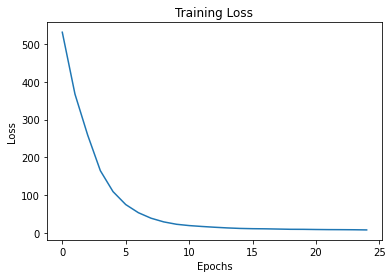

In [ ]:
plt.plot(loss_list)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'MAP')

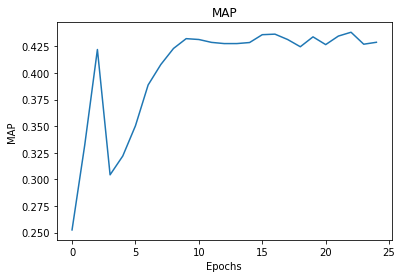

In [ ]:
plt.plot(map_list)
plt.title("MAP")
plt.xlabel("Epochs")
plt.ylabel("MAP")

In [ ]:
# torch.save(yolo_net,"/content/drive/My Drive/yolo_final_new_loss.h5")

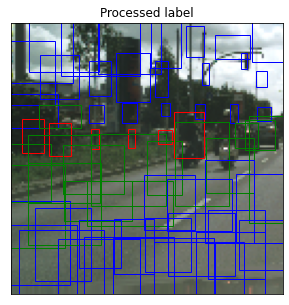

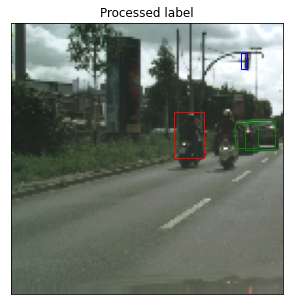

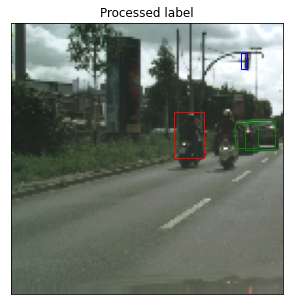

In [129]:
# yolo_net = torch.load("/content/drive/My Drive/yolo_final_new_loss.h5")
# yolo_net = torch.load("/content/drive/My Drive/yolo_final.h5")

yolo_net = yolo_net.to("cpu")
image = torch.tensor(np.expand_dims(test_images[18].transpose(2,0,1),0))
img = image.detach().numpy()[0].transpose(1,2,0)
yolo_net.eval()

out = yolo_net(image.float())

# Network prediction
out_mod = out.detach().clone().numpy()[0]
draw_b_box(img,out_mod)

out_mod[0,out_mod[0,:,:]>=0.3] = 1
out_mod[0,out_mod[0,:,:]<0.3] = 0

draw_b_box(img,out_mod)

mod_pred = NMS(out[0])

draw_b_box(img,mod_pred)

0.3574208582811776
0.6181314337637965
0.31124820468510084
0.4289333559322397


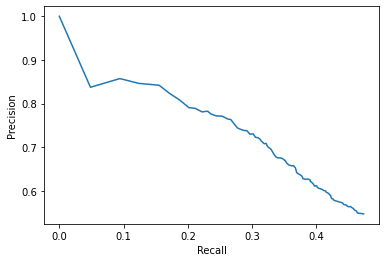

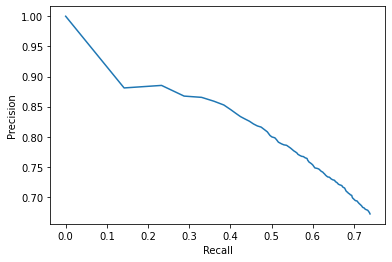

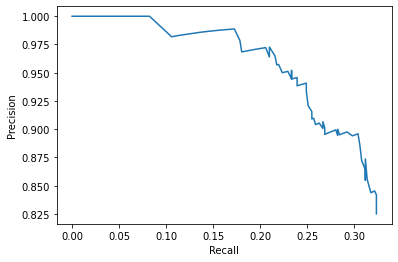

In [114]:
yolo_net = yolo_net.to("cuda")
yolo_net.eval()
map = MAP(yolo_net,test_images,test_raw_labels,device)
print(map)